## Imports

In [3]:
# PYTORCH IMPORTS
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# GENERAL imports
import os
import time
import pickle
import scipy
import numpy as np
from collections import Counter
import random
import copy

# Math, stats, and data visualization
import math
import scipy
import matplotlib.pyplot as plt

# Sklearn
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelBinarizer

## Sources / notes

- Original paper this notebook is based off of https://www.eng.biu.ac.il/goldbej/files/2012/05/icassp_2016_Alan.pdf (Training deep neural-networks based on unreliable labels) <br>
- Much of the EM code is copied or adapted from https://github.com/Ryo-Ito/Noisy-Labels-Neural-Network as well as some of the data visualization. This notebook uses Pytorch+Numpy whereas the code it is based off of uses Chainer+Numpy
- MLP structure and training loops are similar to Patrick Loebers pytorch videos https://www.youtube.com/watch?v=0_PgWWmauHk, and usability/generality is mildly inspired by sklearns mlp
- Another helpful link regarding this topic https://github.com/subeeshvasu/Awesome-Learning-with-Label-Noise
- Random seed funtionality for batching / training is not included, but could be added, or switch to pytorch native batching / loader functions

## Analysis code

In [4]:
##############################################
##############################################
### Default MLP, training, assessment code ###

# Base clase of mlp that is used
class MLP(nn.Module):
    """
    Generalized mlp where an arbitrary number of layers and sizes can be set along with various activation functions.
    
    input_size int: initial array input size for any given sample
    hidden_size list: list of hidden layer sizes. [500] will give a single (hidden) layer mlp of hidden layer size 500. [500, 400] will give a two layer mlp with sizes 500 and 400...
    num_classes int: number of possible labels in the dataset
    device pytorch_device: initialized cpu or mps device type via pytorch
    activation str: Relevant activation function we wish to use
    """
    def __init__(self, input_size, hidden_size, num_classes, device, activation="ReLU"):
        super(MLP, self).__init__()
        
        # Initiate our global dictionary of supported activation functions, 
        # and pre process our hidden_sizes for easy layer input output initiation
        activation_functions = {"ReLU":nn.ReLU(),
                                "Tanh":nn.Tanh()}
        
        # Set our hidden_sizes attribute for the future
        # Important to make a copy here, so we can re-use hidden_size for other independent models
        # If a copy is not made, the the hidden_size argument will be added to outside of the __init__ function
        self.hidden_size = copy.copy(hidden_size)
        self.hidden_size.insert(0, input_size)
        self.hidden_size.append(num_classes)
        
        # Set our activation function
        self.activation_function = activation_functions[activation]
        
        # Set our initial layers and give to device
        self.set_layers = self.set_layers()
        self.set_layers_to_device(device)
        
    def set_layers(self):
        """
        Should only be called a single time to initiate the various layers of the network
        """
        for i in range(1, len(self.hidden_size)):
            setattr(self, "l{}".format(i), nn.Linear(self.hidden_size[i-1], self.hidden_size[i]))
    
    def set_layers_to_device(self, device):
        """
        We do this in a separate step so that we can switch devices in need be.
        For example, it appears to be much faster to train on the gpu, but for predictions it is much faster on the cpu.
        This function allows us to pre allocate memory to cpu or gpu rather than being locked into one or the other
        """
        for i in range(1, len(self.hidden_size)):
            getattr(self, "l{}".format(i)).to(device)
        self.device = device
    
    def forward(self, x):
        """
        Forward propogation loop.
        """
        
        out = x
        for i in range(1, len(self.hidden_size)-1):
            out = getattr(self, "l{}".format(i))(out)
            out = self.activation_function(out)
        
        # Final calculation for output (no activation or softmax)
        out = getattr(self, "l{}".format(i+1))(out)
        return out

    def batch_sample_indices(self, input_data, batch_size=250, batch_type="random"):
        """
        batch_type argument can be random or linear  
        Will return a batch like structure of indices to sample from, using a random sample without replacement methodology
        """

        batch_indices = []
        sample_indices_list = [i for i in range(0, len(input_data))]
        sample_indices_set = set(sample_indices_list)

        # Start our random sampling without replacement loop and deal with all our edge cases in the process
        index = 0
        while True:

            # Scenario that signifies the potential LAST case in the loop, hence why we are allowed alter the input variable here
            if len(sample_indices_set) < batch_size:
                batch_size = len(sample_indices_set)

            # Grab sample indices for linear style indexing
            if batch_type == "linear":
                sample_inds = sample_indices_list[index:index+batch_size]
                index += batch_size

            # Random sample our batch size from ever shrinking input list
            elif batch_type == "random":
                sample_inds = random.sample(list(sample_indices_set), batch_size)
            
            else:
                print("- ERROR... Invalid batch_type argument of {}".format(batch_type))
                return

            # Deal with potential edge case
            if len(sample_inds) == 0:
                break

            # Update our input information to take into account the sampling
            sample_indices_set = sample_indices_set - set(sample_inds)
            batch_indices.append(sample_inds)

            # Final edge case scenario
            if len(sample_indices_set) == 0:
                break

        return batch_indices
   
    def predict(self, data, device, batch_size=10000):
        """
        Calculates prediction raw values, and prediction labels for our data. 
        Uses a hardcoded linear batch structure to keep labels and probs consistent.
        Additionally, we would like to revert the network back to whichever device it was originally trained on...
        This allows us to train and test our data using a gpu+cpu combo instead of being locked into a single device
        """
        
        # Set our device type here... CPU or MPS is allowed
        if device == 'cpu':
            device = torch.device('cpu')
        elif device == 'mps':
            device = torch.device('mps')
        else:
            print("- ERROR... cpu or mps is allowed... {} is not valid".format(device))
            return
        
        # Allocate memory to initiated device for our model and keep track of old device so we can revert back to it
        org_device = str(self.device)
        self.set_layers_to_device(device)
        
        # Test the model via pytorch
        # In the test phase we don't need to compute the gradient 
        probs, preds = [], []
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            
            # Create our pre batch index information
            batch_inds = self.batch_sample_indices(data, batch_size=batch_size, batch_type="linear")

            # Loop through each batch, initiate data from indicies, and predict
            for inds in batch_inds:

                # Create our batch data 
                data_batch = torch.from_numpy(np.asarray([data[ind] for ind in inds])).float().to(device)
                outputs = self(data_batch)
                _, predicted = torch.max(outputs.data, 1)
                
                # Obtain probabilities by applying softmax to output layer (https://discuss.pytorch.org/t/how-to-extract-probabilities/2720/14)
                sm = torch.nn.Softmax(dim=1)
                probabilities = sm(outputs).cpu().numpy() # Must copy to cpu from gpu (if we are using gpu. Gives same result if cpu is used)
                
                # Add our batch probs and predictions to our lists
                probs.append(probabilities)
                preds.append(predicted)
        
        # Convert our probabilities and predictions (ie argmax of probs) to np arrays
        probs = np.asarray([ppp for pp in probs for ppp in pp])
        preds = np.asarray([ppp.cpu() for pp in preds for ppp in pp])
        
        # Before we return our data, we want to revert our model back to its original device usage by calling the set_layers to device with the original device (rather than the one passed in)
        # This allows us to test our model accuracy after any given epoch or batch and resume training using the original device we wanted
        # This is useful because predctions appear to be much faster on cpu rather than gpu... This allows us to flip between the two during traing time
        if org_device == 'cpu':
            device = torch.device('cpu')
        elif org_device == 'mps':
            device = torch.device('mps')
        self.set_layers_to_device(device)
        
        return probs, preds
    
# Default training loop for mlp
def train_mlp_model(data, labels, input_size, hidden_size, num_classes, num_epochs, batch_size, learning_rate=.001, device='cpu', activation="ReLU", plateau=10, verbose=False, early_stop=False, test_acc_data=False):
    """
    Assumes input data and labels are of np array type, which are then converted to tensors during training / batching
    """
    
    # Set our device type here... cpu or mps is allowed
    if device == 'cpu':
        device = torch.device('cpu')
        dstring = 'cpu'
    elif device == 'mps':
        device = torch.device('mps')
        dstring = 'mps'
    else:
        print("- ERROR... cpu or mps is allowed... {} is not valid".format(device))
        return
        
    # Make sure our hidden layer formatting is correct
    if type(hidden_size) != type([]):
        print("- ERROR... hidden_size should be a list of HIDDEN layer sizes desired for the network. Input and output layer not inlcuded... {} is not valid".format(hidden_size))
        return
    
    # Ensure data integrity
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Setup our naive model, Loss function
    model = MLP(input_size, hidden_size, num_classes, device, activation=activation)
    criterion = nn.CrossEntropyLoss()
    
    # Set up our optimization function and,
    # utilize pytorch's built in functionality of setting up an output container structure ready for input into the optimizer.
    # Because of the way we named our layers in the MLP object (l1, l2, l3, l4, etc...) model.parameters() is set in the same order automatically under the hood.
    # Therefore, we can just call upon it as is :)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    #print("- Model and hyper parameters initiated...")
    #print("- Starting training loop according to batching parameters...")
    
    # Set up our loss record keeping, and make initial loss a huge number by default
    loss_record = []
    min_loss = 1000000000
    loss_min_increase = learning_rate / 10.
    
    # Loop through training regime
    for ep in range(0, num_epochs):
        
        #print("- Epoch {}/{} initiated...".format(ep+1, num_epochs))
        
        # Create our pre batch index information
        batch_inds = model.batch_sample_indices(data, batch_size=batch_size)
        
        # Loop through each batch, initiate data from indicies, and train
        for inds in batch_inds:
            
            # Create our batch data 
            data_batch = torch.tensor(data[[ind for ind in inds]]).float().to(device)
            data_labels = torch.tensor(labels[[ind for ind in inds]]).to(device)
            
            # Forward pass
            outputs = model(data_batch)
            loss = criterion(outputs, data_labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

        # Gather loss info
        loss_record.append(loss.item())
        
        # Deal with verbose option
        if verbose == True:
            print("- Epoch {}/{}, Loss {}".format(ep+1, num_epochs, loss.item()))
        
        # Assess model accuraccy (on passed in test data)
        if test_acc_data != False:
            pprobs, ppreds = model.predict(test_acc_data[0], device=dstring)
            acc = calc_multiclass_accuracy(pprobs, test_acc_data[1]) # Where both predictions and labels are softmaxed (because we can do that here :))
            print("- Test-Data accuracy {}% , Epoch {}".format(acc, ep+1))
        
        # Deal with our stopping / treading water condition
        if (loss_record[-1] + loss_min_increase) >= min_loss:
            non_improve_rounds += 1
        else:
            non_improve_rounds = 0
            min_loss = loss_record[-1]
        
        if non_improve_rounds >= plateau:
            #print("- Training did not improve loss score after {} plateau rounds... exiting training loop".format(plateau))
            print("- Epochs completed {}/{}, Loss {}".format(ep+1, num_epochs, loss.item()))
            break
        
        # Deal with early_stop option
        if early_stop != False:
            if loss_record[-1] <= early_stop:
                print("- Training terminated by early_stop function (loss <= {}), current loss = {}".format(early_stop, loss_record[-1]))
                break
        
        
        
    return model                  

# Confusion matrix of all the different labels available (uses some sklearn plotting functions)
def assess_model_confmat(model, train_samps, train_labels, test_samps, test_labels, predict_samples=True):
    
    # We can pass in samples OR a precomputed set of predictions...
    if predict_samples == True:
        train_preds = model.predict(train_samps)[1]
        test_preds = model.predict(test_samps)[1]
    
    else:
        train_preds = train_samps
        test_preds = test_samps
    
    fig = plt.figure()
    plt.rcParams.update({'font.size': 8})
    fig.set_size_inches(18, 9)
    ax1 = plt.subplot2grid((2, 3), (0, 0)) # Training unormalized
    ax2 = plt.subplot2grid((2, 3), (0, 1)) # Training pred normalized
    ax3 = plt.subplot2grid((2, 3), (0, 2)) # Training all normalized

    ax4 = plt.subplot2grid((2, 3), (1, 0)) # Test unormalized
    ax5 = plt.subplot2grid((2, 3), (1, 1)) # Test pred normalized
    ax6 = plt.subplot2grid((2, 3), (1, 2)) # Test all normalized
    
    t = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(train_labels, train_preds, normalize=None, cmap="plasma", values_format=format(','), ax=ax1)
    t = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(train_labels, train_preds, normalize="pred", cmap="plasma", values_format=".1%", ax=ax2)
    t = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(train_labels, train_preds, normalize="all", cmap="plasma", values_format=".1%", ax=ax3)

    t = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, normalize=None, cmap="plasma", values_format=format(','), ax=ax4)
    t = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, normalize="pred", cmap="plasma", values_format=".1%", ax=ax5)
    t = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, normalize="all", cmap="plasma", values_format=".1%", ax=ax6)


    ax1.set_title("Unormalized prediction counts (TRAINING DATA)")
    ax2.set_title("Prediction count normalized % (TRAINING DATA)")
    ax3.set_title("All count normalized % (TRAINING DATA)")

    ax4.set_title("Unormalized prediction counts (TEST DATA)")
    ax5.set_title("Prediction count normalized % (TEST DATA)")
    ax6.set_title("All count normalized % (TEST DATA)")

    plt.tight_layout(pad=2.0)
    plt.show()
    plt.close(fig)      

# Assumes predictions and labels are a single value rather than a softmax probability vector
def calc_accuracy(preds, labels):
    
    # Figure out where the indicies match the labels (ie the highest probability index should match the label since our labels are digits)
    c = np.count_nonzero(preds==labels)
    
    # Convert to percent and return
    f = len(preds) - c
    pr = round((c/(c+f)) * 100., 2)
    return pr

# Assumes predictions are created from softmax function so we need to find the largest index and compare to labels 
def calc_multiclass_accuracy(preds, labels):
    # Calculate indices of highest values of the 1st dimension of the dataset
    pred_inds = np.argmax(preds, 1)
    
    # Figure out where the indicies match the labels (ie the highest probability index should match the label since our labels are digits)
    c = np.count_nonzero(pred_inds==labels)
    
    # Convert to percent and return
    f = len(preds) - c
    pr = round((c/(c+f)) * 100., 2)
    return pr

# Assumes both predictions and labels are derived from softmax functions so we need to find the largest index of both and compare
def calc_multiclass_accuracy_labelsoftmax(preds, labels):
    # Calculate indices of highest values of the 1st dimension of the datasets
    pred_inds = np.argmax(preds, 1)
    lab_inds = np.argmax(labels, 1)
    
    # Figure out where the indicies match the labels (ie the highest probability index should match the label)
    c = np.count_nonzero(pred_inds==lab_inds)
    
    # Convert to percent and return
    f = len(preds) - c
    pr = round((c/(c+f)) * 100., 2)
    return pr



########################################
########################################
### Data loading and conversion code ###

# Convert pytorch loader data to arrays if need be
def convert_loader_data_to_arrays(loader):
    """
    Expects a pytorch data loader like object
    By default, will flatten the entire batch structure --> single samples
    """
    
    convert_data, convert_labels = [], []
    #for data, data_labels in loader:
    
    for data, data_labels in loader:
        
        # Assumes batch like structure where the dimensions should be [batch_size, 1, sample_dim1, sample_dim2]
        data = data.reshape(-1, data.shape[2]*data.shape[3])
        for dd in data:
            convert_data.append(dd.numpy())
        
        for ll in data_labels:
            convert_labels.append(int(ll))
    
    return np.asarray(convert_data), np.asarray(convert_labels) 

# Load pytorch minst or cifar10 datasets
def initiate_data_loaders(batch_size_train, batch_size_test, dataset, directory=False, train_samples=False, train_labels=False, test_samples=False, test_labels=False, download=False):
    if dataset == "minst":
        print("- Loading MINST dataset...")
        train_dataset = torchvision.datasets.MNIST(root=directory, train=True, transform=transforms.ToTensor(), download=download)
        test_dataset = torchvision.datasets.MNIST(root=directory, train=False, transform=transforms.ToTensor(), download=download)
    
    elif dataset == "cifar10":
        print("- Loading CIFAR10 dataset...")
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        train_dataset = torchvision.datasets.CIFAR10(root=directory, train=True, download=download, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(root=directory, train=False, download=download, transform=transform)
    
    # If this fails out, then it means we have input something other than false (that casues it to fail) 
    else:
        print("- ERROR - Unexpected dataset argument of {}... minst or cifar10 is excepted".format(dataset))
        return
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=False, drop_last=True)
    return train_loader, test_loader
    


##############################################
##############################################
### Functions are for "noisy" labeled data ###

def maximize_network(data, 
                     labels, 
                     input_size, 
                     hidden_size, 
                     num_classes, 
                     num_epochs, 
                     batch_size, 
                     learning_rate=.001, 
                     device='cpu', 
                     activation="ReLU", 
                     plateau=10, 
                     verbose=False, 
                     early_stop=False, 
                     test_acc_data=False, 
                     pass_in_model=False):
    
    ### Allows us to pass in a pre trained network and pre allocated device... [model, device]
    if pass_in_model != False:
        model, device = pass_in_model
    else:
        # Set our device type here... cpu or mps is allowed
        if device == 'cpu':
            device = torch.device('cpu')
        elif device == 'mps':
            device = torch.device('mps')
        else:
            print("- ERROR... cpu or mps is allowed... {} is not valid".format(device))
            return
        
    # Make sure our hidden layer formatting is correct
    if type(hidden_size) != type([]):
        print("- ERROR... hidden_size should be a list of HIDDEN layer sizes desired for the network. Input and output layer not inlcuded... {} is not valid".format(hidden_size))
        return

    # Ensure data integrity
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Setup our naive model, Loss function
    model = MLP(input_size, hidden_size, num_classes, device, activation=activation)
    criterion = nn.CrossEntropyLoss()
    
    # Set up our optimization function and,
    # utilize pytorch's built in functionality of setting up an output container structure ready for input into the optimizer.
    # Because of the way we named our layers in the MLP object (l1, l2, l3, l4, etc...) model.parameters() is set in the same order automatically under the hood.
    # Therefore, we can just call upon it as is :)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Set up our loss record keeping, and make initial loss a huge number by default
    loss_record = []
    min_loss = 1000000000
    loss_min_increase = learning_rate / 10.
    
    # Loop through training regime
    for ep in range(0, num_epochs):
        
        #print("- Epoch {}/{} initiated...".format(ep+1, num_epochs))
        
        # Create our pre batch index information
        batch_inds = model.batch_sample_indices(data, batch_size=batch_size)
        
        # Loop through each batch, initiate data from indicies, and train
        for inds in batch_inds:
            
            # Create our batch data 
            data_batch = torch.tensor(np.float32(data[[ind for ind in inds]])).to(device)
            data_labels = torch.tensor(np.float32(labels[[ind for ind in inds]])).to(device)
            
            # Forward pass
            logit = model(data_batch)
            loss = -torch.sum(F.log_softmax(logit, dim=1) * data_labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Gather loss info
        loss_record.append(loss.item())
        
        # Deal with verbose option
        if verbose == True:
            print("- Epoch {}/{}, Loss {}".format(ep+1, num_epochs, loss.item()))
        
        # Deal with our stopping / treading water condition
        if (loss_record[-1] + loss_min_increase) >= min_loss:
            non_improve_rounds += 1
        else:
            non_improve_rounds = 0
            min_loss = loss_record[-1]
        
        if non_improve_rounds >= plateau:
            #print("- Training did not improve loss score after {} plateau rounds... exiting training loop".format(plateau))
            print("- Epochs completed {}/{}, Loss {}".format(ep+1, num_epochs, loss.item()))
            break
        
        # Last but not least deal with early_stop option
        if early_stop != False:
            if loss_record[-1] <= early_stop:
                print("- Training terminated by early_stop function (loss <= {}), current loss = {}".format(early_stop, loss_record[-1]))
                break
        
        # Assess model accuraccy (on passed in test data)
        if test_acc_data != False:
            pprobs, ppreds = model.predict(test_acc_data[0], device='cpu')
            acc = calc_multiclass_accuracy(pprobs, test_acc_data[1]) # Where both predictions and labels are softmaxed (because we can do that here :))
            print("- Epoch {} accuracy {}%".format(ep+1, acc))
    
    return model

def em_maximize_matrix(y_train, z_train, lab_count):
    m = np.zeros((lab_count, lab_count))
    for j in range(0, lab_count):
        indices = np.where(z_train==j)
        for i in range(0, lab_count):
            m[j, i] = np.sum(y_train[indices, i]) / np.sum(y_train[:, i])
    return m

def em_expectation(model, data, data_labs, noise_matrix, lab_count, batch_size=2000):
    
    # Set device to cpu as default here
    device = torch.device("cpu")
    model.set_layers_to_device(device)
    
    # Create our pre batch index information
    label_train = np.zeros((len(data), lab_count))
    batch_inds = model.batch_sample_indices(data, batch_size=batch_size)
    
    # Loop through each batch, initiate data from indicies, and train
    for inds in batch_inds:
        input_batch = torch.from_numpy(np.float32(data[[ind for ind in inds]])).to(device)
        proba = F.softmax(model(input_batch), dim=1).detach().numpy()
        proba *= noise_matrix[[data_labs[ind] for ind in inds]]
        proba /= np.sum(proba, axis=1, keepdims=True)
        
        # Alter label probs
        for i, ii in enumerate(inds):
            label_train[ii] = proba[i]
            
    return label_train



#####################################################
#####################################################
### Visualization of the labels that were changed ###

def vis_data_via_picture(data, old_labels, new_labels, subplots=10, reshape_size1=28, reshape_size2=28):
    
    fig, ax = plt.subplots(subplots, subplots)
    fig.set_size_inches(subplots, subplots)
    ind = 0
    
    for i in range(0, subplots):
        for ii in range(0, subplots):
            
            # Allows us to highlight changed labels 
            if old_labels[ind] != new_labels[ind]:
                ax[i, ii].patch.set_edgecolor('red')
                ax[i, ii].patch.set_linewidth('10')
            
            title_color = 'black'
            ax[i, ii].imshow(data[ind].reshape(reshape_size1, reshape_size2), cmap="gray")
            ax[i, ii].set_title("{}->{}".format(old_labels[ind], new_labels[ind]), fontsize=8, y=.9, color=title_color)
            
            # If we want to highlight a particular subplot, then we cannot turn off the axis...
            # So we must instead "turn off" the ticks to get clean looking axis
            ax[i, ii].set_xticks([])
            ax[i, ii].set_yticks([])
            #ax[i, ii].axis("off")
            
            ind += 1

    plt.show()
    plt.close(fig)
    
def tally_changed_labels(old_labels, new_labels):
    
    # Initiate our counting datastructure
    old_lab_set = set(old_labels)
    new_lab_set = set(new_labels)
    changed_lab_counts = {lab:{lab2:0 for lab2 in new_lab_set} for lab in old_lab_set}
    
    # Count our altered labels
    for i in range(0, len(old_labels)):
        ol, nl = old_labels[i], new_labels[i]
        changed_lab_counts[ol][nl] += 1
    
    return changed_lab_counts

## Baseline model with clean labels

In [4]:
# Data loacation and Hyer parameters
TRAINING_DIRECTORY = "/Users/ao/Desktop/NN_TESTING/mnist/data/"
NUM_CLASSES = 10
INPUT_SIZE = 784 # 28 x 28 for mnist dataset
HIDDEN_SIZE = [500, 300]
BATCH_SIZE = 1000
NUM_EPOCHS = 5
LEARNING_RATE = .001
DEVICE = "mps"

In [5]:
# Initiate our data sets
train_loader, test_loader = initiate_data_loaders(BATCH_SIZE, BATCH_SIZE, "minst", directory=TRAINING_DIRECTORY, train_samples=False, train_labels=False, test_samples=False, test_labels=False)

# Convert to arrays
tdat, tlab  = convert_loader_data_to_arrays(train_loader)  # Training data, training labels
tedat, telab  = convert_loader_data_to_arrays(test_loader) # Test data, test labels

- Loading MINST dataset...


In [6]:
# Train our model          
model = train_mlp_model(tdat, 
                        tlab, 
                        INPUT_SIZE, 
                        HIDDEN_SIZE, 
                        NUM_CLASSES,
                        NUM_EPOCHS, 
                        BATCH_SIZE, 
                        learning_rate=LEARNING_RATE, 
                        device=DEVICE, 
                        activation="ReLU",
                        verbose=True, # False
                        test_acc_data=False) # [tedat,telab]) Can test our accuraccy every epoch if want, (much slower to do so)

print("- Test data accuracy {}%".format(calc_multiclass_accuracy(model.predict(tedat, device="cpu", batch_size=10000)[0], telab)))

- Epoch 1/5, Loss 0.30401504039764404
- Epoch 2/5, Loss 0.19293095171451569
- Epoch 3/5, Loss 0.1042315810918808
- Epoch 4/5, Loss 0.1302243173122406
- Epoch 5/5, Loss 0.10969630628824234
- Test data accuracy 97.01%


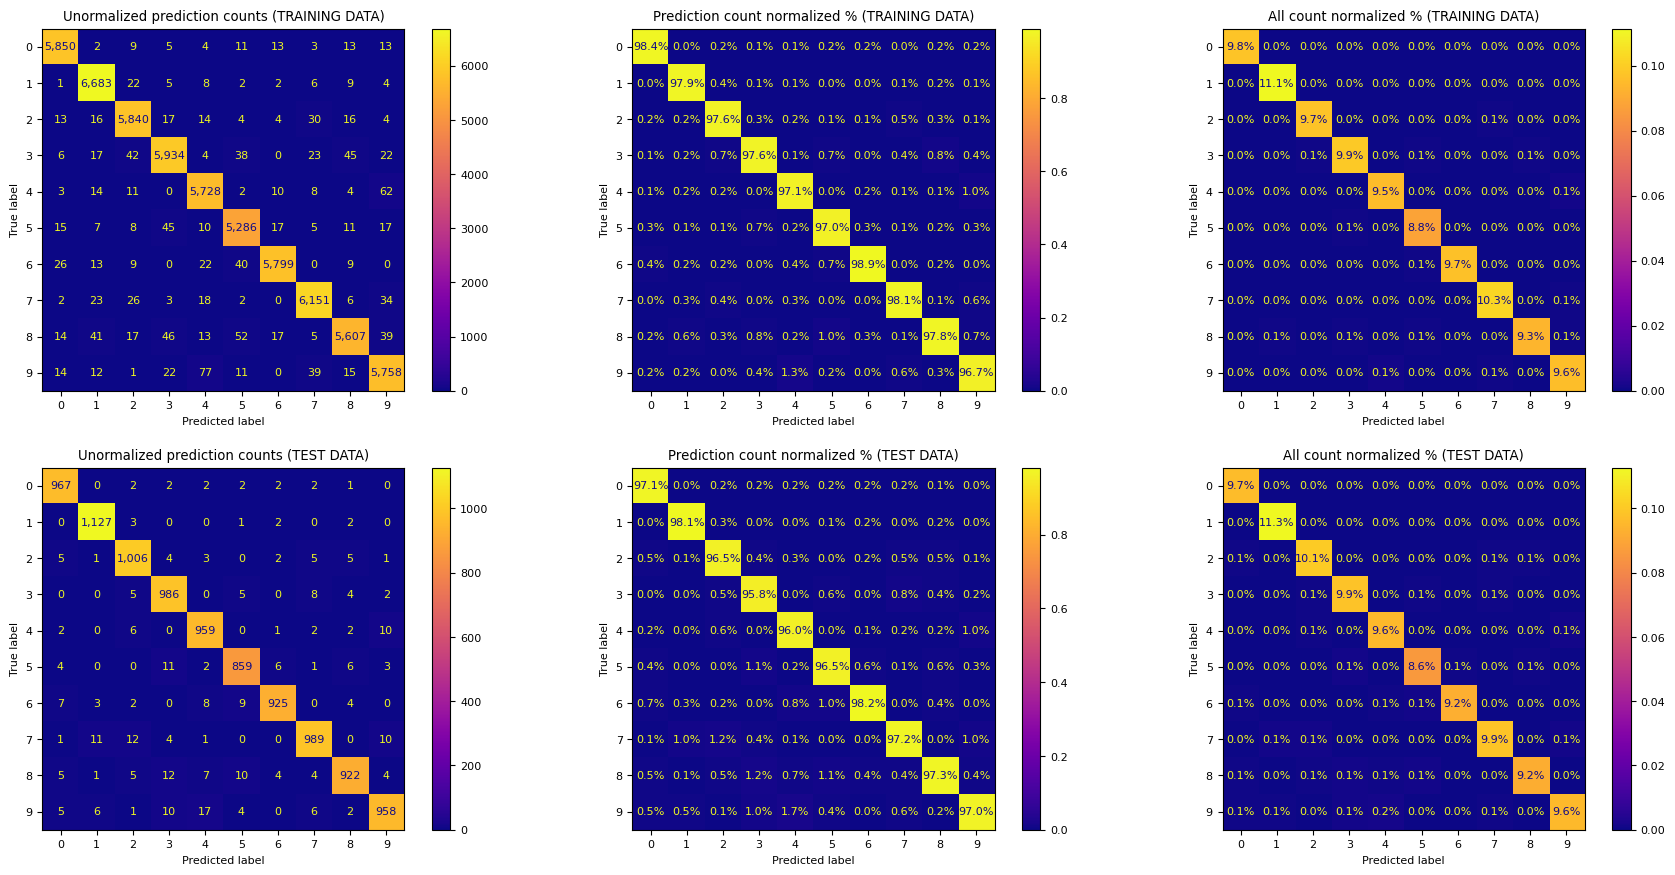

In [6]:
# Model assessment
train_probs, train_preds = model.predict(tdat, "cpu", batch_size=10000)
test_probs, test_preds = model.predict(tedat, "cpu", batch_size=10000)
assess_model_confmat(model, train_preds, tlab, test_preds, telab, predict_samples=False)

## Noisy label correction with EM training

In [8]:
# Data loacation and Hyer parameters
TRAINING_DIRECTORY = "/Users/ao/Desktop/NN_TESTING/mnist/data/"
NUM_CLASSES = 10
INPUT_SIZE = 784 # 28 x 28 for mnist dataset
HIDDEN_SIZE = [500, 300]
BATCH_SIZE = 1000
NUM_EPOCHS = 5
EM_STEP = 1
NOISE_RATIO = .5
LEARNING_RATE = .001
DEVICE = "mps"

In [9]:
# Initiate our data sets
train_loader, test_loader = initiate_data_loaders(BATCH_SIZE, BATCH_SIZE, "minst", directory=TRAINING_DIRECTORY, train_samples=False, train_labels=False, test_samples=False, test_labels=False)

# Convert to arrays
tdat, tlab  = convert_loader_data_to_arrays(train_loader)
tedat, telab  = convert_loader_data_to_arrays(test_loader)

# Add random noise to data
tlab_org = np.copy(tlab)
random_noise_inds = random.sample([i for i in range(0, len(tlab))], int(len(tlab) * NOISE_RATIO))
tlab[random_noise_inds] = [random.randint(0, NUM_CLASSES-1) for i in range(0, len(random_noise_inds))]

# Calculate our newely incorporated noise compared to original labels
bc = np.count_nonzero(tlab_org==tlab)
print("- Baseline accuraccy of noisy labels comapred to original {}%".format(round((bc/len(tlab_org)) * 100., 2)))

# Initiate our em version of the labels and noise matrix
em_labels = np.copy(tlab)
em_labels = np.int32(LabelBinarizer().fit_transform(em_labels))
noise_matrix = np.ones((NUM_CLASSES, NUM_CLASSES)) / 10.

- Loading MINST dataset...
- Baseline accuraccy of noisy labels comapred to original 54.96%


In [10]:
# Initial training 
model = maximize_network(tdat, 
                         em_labels, 
                         INPUT_SIZE, 
                         HIDDEN_SIZE, 
                         NUM_CLASSES,
                         NUM_EPOCHS, 
                         BATCH_SIZE, 
                         learning_rate=LEARNING_RATE, 
                         device=DEVICE, 
                         activation="ReLU",
                         verbose=True,
                         test_acc_data=False) # [tedat, telab]) If we want to test accuracy after each epoch (a bit slow)

print("- Test data accuracy {}%".format(calc_multiclass_accuracy(model.predict(tedat, device="cpu", batch_size=10000)[0], telab)))

- Epoch 1/5, Loss 1755.087646484375
- Epoch 2/5, Loss 1748.2259521484375
- Epoch 3/5, Loss 1687.598388671875
- Epoch 4/5, Loss 1775.336181640625
- Epoch 5/5, Loss 1710.8533935546875
- Test data accuracy 95.83%


In [11]:
# EM steps 
for i in range(1, EM_STEP+1):
    print("===============================")
    print("- EM step {}".format(i))
    
    em_labels = em_expectation(model, tdat, tlab, noise_matrix, NUM_CLASSES, device=device, batch_size=BATCH_SIZE)
    altered_acc = calc_multiclass_accuracy(em_labels, tlab_org)
    print("- EM expectation complete... accuracy of new labels {}%".format(altered_acc))
    
    noise_matrix = em_maximize_matrix(em_labels, tlab, NUM_CLASSES)
    print("- EM maximization complete...")
    
    print('- "Corrected" label accuracy {}%'.format(calc_multiclass_accuracy(em_labels, tlab_org)))
    
    model = maximize_network(tdat, 
                             em_labels, 
                             INPUT_SIZE, 
                             HIDDEN_SIZE, 
                             NUM_CLASSES,
                             NUM_EPOCHS, 
                             BATCH_SIZE, 
                             learning_rate=LEARNING_RATE, 
                             device=DEVICE, 
                             activation="ReLU",
                             verbose=False,
                             test_acc_data=[tedat, telab],
                             pass_in_model=False) #[model, model.device])
    
em_labels = em_expectation(model, tdat, tlab, noise_matrix, NUM_CLASSES, batch_size=BATCH_SIZE)
em_labels = np.argmax(em_labels, -1)
print("- EM training complete...")
print("- Test data accuracy {}%".format(calc_multiclass_accuracy(model.predict(tedat, device="cpu", batch_size=10000)[0], telab)))

- EM step 1
- EM expectation complete... accuracy of new labels 95.96%
- EM maximization complete...
- "Corrected" label accuracy 95.96%
- Epoch 1 accuracy 92.58%
- Epoch 2 accuracy 94.87%
- Epoch 3 accuracy 95.39%
- Epoch 4 accuracy 95.62%
- Epoch 5 accuracy 95.71%
- EM training complete...
- Test data accuracy 95.71%


- Noisy label accuracy 54.96%
- "Corrected" label accuracy 93.81%


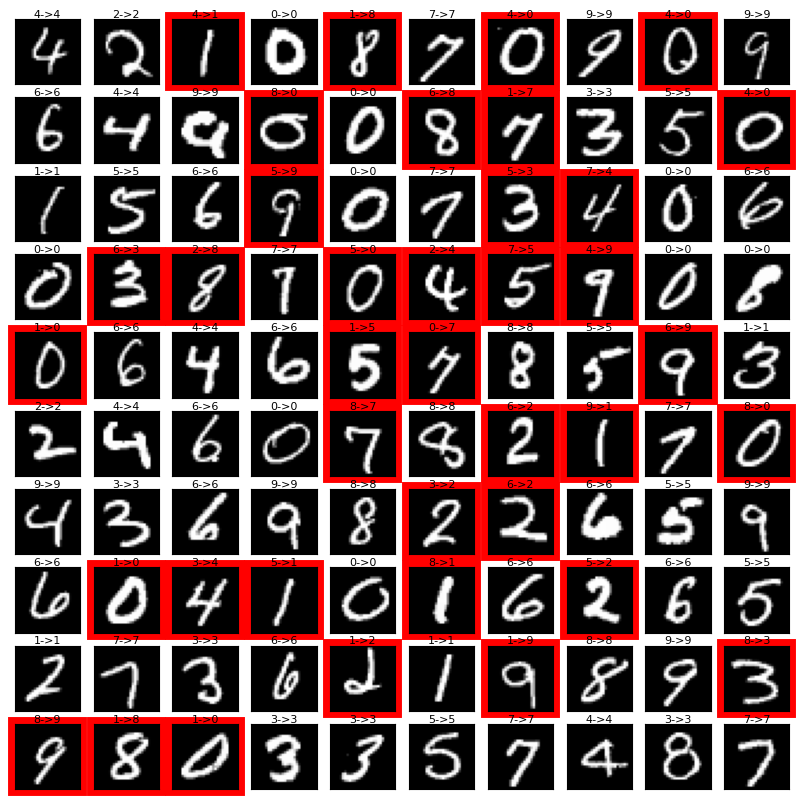

In [12]:
# Will create a 10 x 10 set of images, by resizing our input vectors back to their original shape (28x28 pixels)
# Labels that were altered during em process will be in red
print("- Noisy label accuracy {}%".format((round((bc/len(tlab_org)) * 100., 2)))) # Thses values are initiated in the data initiation cell
print('- "Corrected" label accuracy {}%'.format(calc_accuracy(em_labels, tlab_org)))
vis_data_via_picture(tdat, old_labels=tlab, new_labels=em_labels, subplots=10, reshape_size1=28, reshape_size2=28)

Noisy label improvment seems to decrease after the very first EM step using the current training strategy (95.96% --> 93.81%). The original papers training regime might yield better results

In [13]:
# Simple way of tallying the switching of labels
changed_labs = tally_changed_labels(old_labels=tlab, new_labels=em_labels)
for i in range(0, 10):
    print("### {} --> ? ###".format(i))
    print("{} --> {}".format(i, changed_labs[i]))

### 0 --> ? ###
0 --> {0: 3632, 1: 345, 2: 279, 3: 263, 4: 221, 5: 232, 6: 244, 7: 278, 8: 223, 9: 274}
### 1 --> ? ###
1 --> {0: 292, 1: 3927, 2: 313, 3: 276, 4: 253, 5: 237, 6: 278, 7: 310, 8: 245, 9: 295}
### 2 --> ? ###
2 --> {0: 233, 1: 320, 2: 3787, 3: 247, 4: 243, 5: 221, 6: 199, 7: 289, 8: 184, 9: 250}
### 3 --> ? ###
3 --> {0: 259, 1: 340, 2: 255, 3: 3747, 4: 248, 5: 214, 6: 277, 7: 304, 8: 196, 9: 274}
### 4 --> ? ###
4 --> {0: 309, 1: 334, 2: 287, 3: 305, 4: 3465, 5: 239, 6: 261, 7: 327, 8: 240, 9: 281}
### 5 --> ? ###
5 --> {0: 302, 1: 301, 2: 322, 3: 254, 4: 263, 5: 3209, 6: 230, 7: 301, 8: 208, 9: 245}
### 6 --> ? ###
6 --> {0: 280, 1: 323, 2: 280, 3: 291, 4: 243, 5: 227, 6: 3494, 7: 290, 8: 240, 9: 291}
### 7 --> ? ###
7 --> {0: 280, 1: 314, 2: 316, 3: 248, 4: 210, 5: 224, 6: 257, 7: 3688, 8: 232, 9: 233}
### 8 --> ? ###
8 --> {0: 277, 1: 326, 2: 282, 3: 279, 4: 242, 5: 202, 6: 230, 7: 300, 8: 3405, 9: 250}
### 9 --> ? ###
9 --> {0: 302, 1: 343, 2: 287, 3: 271, 4: 228, 5